0) **Imports**

In [1]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


1) **Consititutive behaviour Definition**

Strain Energy
$$
\psi(\varepsilon(u)) = \frac{\lambda}{2}
( tr {\varepsilon}^2 + \frac{\alpha}{2} tr {\varepsilon}^4) + 
\mu ( |\varepsilon|^2  + \frac{\alpha}{2} |\varepsilon|^4).
$$

In [2]:
# fetricks is a set of utilitary functions to facilitate our lives
from fetricks.mechanics.elasticity_conversions import youngPoisson2lame
nu = 0.3 
E = 100.0 
alpha = 10e4
lamb, mu = youngPoisson2lame(nu, E)

# alpha : Equivalent to sig = lamb*df.div(u)*df.Identity(2) + mu*(df.grad(u) + df.grad(u).T)
def psi_e(e):
    tr_e = df.tr(e)
    e2 = df.inner(e,e)
    
    return (0.5*lamb*(tr_e**2 + 0.5*alpha*tr_e**4) +
           mu*(e2 + 0.5*alpha*e2**2))

psi = lambda w: psi_e(0.5*(df.grad(w) + df.grad(w).T))

2) **Mesh**  

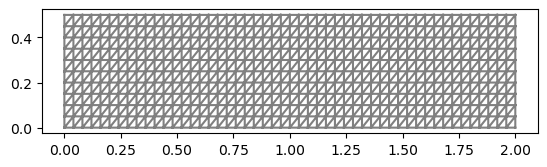

In [3]:
Nx =  50 
Ny =  10 
Lx = 2.0
Ly = 0.5
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'right');
df.plot(mesh);

3) **Mesh regions** 

In [4]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

clampedBndFlag = 1
loadBndFlag = 2
boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, clampedBndFlag)
rightBnd.mark(boundary_markers, loadBndFlag)

dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces**

In [5]:
Uh = df.VectorFunctionSpace(mesh, "CG", 1) # Equivalent to CG
bcL = df.DirichletBC(Uh, df.Constant((0.0, 0.0)), boundary_markers, clampedBndFlag)

5. **Variational Formulation**: Minimisation 
\begin{align} 
\min_{u \in U} \left ( J(u):=\int_{\Omega} \psi(u) dx - \Pi_{ext}(u) \right) \\
F(u; v) = \delta J(u;v) = 0 \quad \forall v \in V , \\
\delta F(u, du; v) = \delta^2 J(u, du;v) \quad \forall v \in V ,
\end{align} 
<br>


In [10]:
du = df.TrialFunction(Uh)            # Incremental displacement
v  = df.TestFunction(Uh)             # Test function
uh  = df.Function(Uh)                 # Displacement from previous iteration

ty = -0.1
traction = df.Constant((0.0, ty))

P_ext = df.inner(traction,uh)*ds(loadBndFlag)
P_int = psi(uh)*dx

J = P_int - P_ext

F = df.derivative(J, uh, v)
DF = df.derivative(F, uh, du) # Optional

6) **Solving**

In [11]:
# Compute solution
start = timer()
df.solve(F == 0, uh, bcL, J = DF)
end = timer()

print("Time spent: ", end - start)
print("Norm L2: ", df.assemble(df.inner(uh,uh)*dx))

print("Norm l2: ", np.linalg.norm(uh.vector().get_local()) )
# 0.5066642165089559

Solving nonlinear variational problem.
Time spent:  0.07962071299698437
Norm L2:  0.0004445739506512366
Norm l2:  0.5066642165089658
  Newton iteration 0: r (abs) = 1.541e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.403e+00 (tol = 1.000e-10) r (rel) = 2.208e+02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.007e+00 (tol = 1.000e-10) r (rel) = 6.535e+01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.931e-01 (tol = 1.000e-10) r (rel) = 1.902e+01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 7.507e-02 (tol = 1.000e-10) r (rel) = 4.871e+00 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.064e-02 (tol = 1.000e-10) r (rel) = 6.903e-01 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 2.841e-04 (tol = 1.000e-10) r (rel) = 1.844e-02 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 2.408e-07 (tol = 1.000e-10) r (rel) = 1.562e-05 (tol = 1.000e-09)
  Newton iteration 8: r (abs) = 2.023e-13 (tol = 1.000e-10) r (rel) = 1.313e-11 (to

7. **Pos-Processing**

In [20]:
import fetricks.fenics.postprocessing.wrapper_io as iofe
from fetricks import symgrad_mandel, tensor2mandel

def sigma_law(w):    
    e = 0.5*(df.grad(w) + df.grad(w).T) 
    e = df.variable(e)
    return df.diff(psi_e(e),e)

Sh = df.VectorFunctionSpace(mesh, "DG", 0, dim = 3) 
epsh = df.project( symgrad_mandel(uh), Sh)
sig = sigma_law(uh)
sigh = df.project( tensor2mandel(sig), Sh)

uh.rename("u",'')
epsh.rename("eps",'')
sigh.rename("sig",'')

iofe.exportXDMF_gen("bar_nonlinear_vtk.xdmf", fields={'vertex': [uh], 'cell_vector': [epsh, sigh] })
iofe.exportXDMF_checkpoint_gen("bar_nonlinear_sol.xdmf", fields={'vertex': [uh], 'cell': [epsh, sigh]})

Calling FFC just-in-time (JIT) compiler, this may take some time.


8. **Sanity Check**

In [19]:
# Check for alpha = 0.0 for the linear case
sol_files =  [df.XDMFFile("bar_nonlinear_sol.xdmf"), df.XDMFFile("../linear/bar_sol.xdmf")]

u = []; eps = []; sig = []

for file in sol_files:
    u.append(df.Function(Uh))
    eps.append(df.Function(Sh))
    sig.append(df.Function(Sh))
    
    file.read_checkpoint(u[-1],"u") 
    file.read_checkpoint(eps[-1],"eps")
    file.read_checkpoint(sig[-1],"sig")


print('error L2 disp', np.sqrt(df.assemble( df.inner(u[1] - u[0], u[1] - u[0])*dx) ))
print('error L2 eps', np.sqrt(df.assemble( df.inner(eps[1] - eps[0], eps[1] - eps[0])*dx) ) )
print('error L2 sig', np.sqrt(df.assemble( df.inner(sig[1] - sig[0], sig[1] - sig[0])*dx) ) )

assert np.allclose(u[0].vector().get_local()[:], u[1].vector().get_local()[:])
assert np.allclose(eps[0].vector().get_local()[:], eps[1].vector().get_local()[:])
assert np.allclose(sig[0].vector().get_local()[:], sig[1].vector().get_local()[:]) 

error L2 disp 0.03765547166968704
error L2 eps 0.03444392752955096
error L2 sig 0.24035257432540347


AssertionError: 